# 1. SETTINGS

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import scipy.stats
import os
import time

In [2]:
# helper functions
import functions
from functions import *

In [3]:
# pandas options
pd.set_option('display.max_columns', None)

In [4]:
# white axis labeles
params = {'ytick.color' :     'w',
          'xtick.color' :     'w',
          'axes.labelcolor' : 'w',
          'axes.edgecolor' :  'w'}
plt.rcParams.update(params)

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# garbage collection
import gc
gc.enable()

# 2. DATA PARTITIONING

In [7]:
# import CSV
df = pd.read_csv('../data/data_v3.csv')
print(df.shape)

(500000, 13)


In [8]:
# target variable
target = 'fraud'

In [9]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(1879, 13)
(498121, 13)


In [10]:
# target encoding
y = train[target]
del train[target], test[target]

# 3. MODELING

In [ ]:
# drop bad features
excluded_feats = ['id']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(1879, 11)


In [ ]:
### PARAMETERS

# settings
cores = 8
seed  = 23

# cross-validation
num_folds = 5
shuffle   = True

# muner of rounds
max_rounds = 600
stopping   = 500
verbose    = 200

# LGB parameters
lgb_params = {
    'boosting_type':    'gbdt',
    'objective':        'binary',
    'metric':           'none',
    'subsample':        0.9,
    'feature_fraction': 0.8,
    'lambda_l1':        0.1,
    'lambda_l2':        0.1,
    'min_split_gain':   0.01,
    'min_child_weight': 2,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.05,
    'max_depth':        7,
    'num_leaves':       70,
    'n_estimators':     max_rounds,
    'nthread' :         cores,
    'random_state':     seed,
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [ ]:
# placeholders
clfs = []
valid_profit = np.zeros(num_folds) 
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])
importances  = pd.DataFrame()

In [ ]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
        
    # train lightGBM
    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = prediction_reward, 
                  #eval_metric           = "logloss", 
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
    print('Best iteration is:')
    print('[' + str(best_iter) + ']   valid_1 profit: ' + 
          str(prediction_reward(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1])[1].astype('int')))
       
    # predictions
    preds_oof[val_idx]    = clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]
    valid_profit[n_fold]  = prediction_reward(val_y, preds_oof[val_idx])[1]
    preds_test           += clf.predict_proba(test[features], num_iteration = best_iter)[:, 1] / folds.n_splits 
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = n_fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('----------------------')
    print('FOLD%2d: PROFIT = %.0f' % (n_fold + 1, valid_profit[n_fold]))
    print('----------------------')
    print('')
    
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = np.sum(valid_profit)
print('----------------------')
print('TOTAL PROFIT = %.0f' % cv_perf)
print('----------------------')

Custom early stopping: select the best out of 600 iterations...
[200]	training's profit: 415	valid_1's profit: 95
[400]	training's profit: 415	valid_1's profit: 85
[600]	training's profit: 415	valid_1's profit: 85
Best iteration is:
[103]   valid_1 profit: 95
----------------------
FOLD 1: PROFIT = 95
----------------------

Custom early stopping: select the best out of 600 iterations...
[200]	training's profit: 415	valid_1's profit: 30
[400]	training's profit: 415	valid_1's profit: 20
[600]	training's profit: 415	valid_1's profit: 20
Best iteration is:
[100]   valid_1 profit: 30
----------------------
FOLD 2: PROFIT = 30
----------------------

Custom early stopping: select the best out of 600 iterations...
[200]	training's profit: 415	valid_1's profit: 75
[400]	training's profit: 415	valid_1's profit: 75
[600]	training's profit: 415	valid_1's profit: 75
Best iteration is:
[130]   valid_1 profit: 75
----------------------
FOLD 3: PROFIT = 75
----------------------

Custom early stoppi

In [272]:
##### RECHECK PROFIT  
prediction_reward(y, preds_oof)


###### TRACKING RESULTS

# V1: lgb, 5 folds, default feats:  80
# V2: add feature = total items:    250
# V3: logloss for ES, not profit:   260
# V4: add feature = weird actions:  275
# V5: custom earlystop for profit:  320

('profit', 320.0, True)

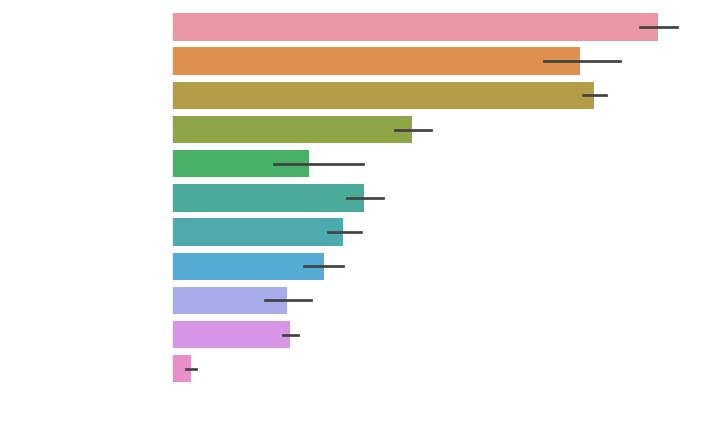

In [273]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10,6))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()

# save plot as pdf
plt.savefig('../var_importance.pdf')

- optimal cutoff = 0.4900
- optimal profit = 320.0000


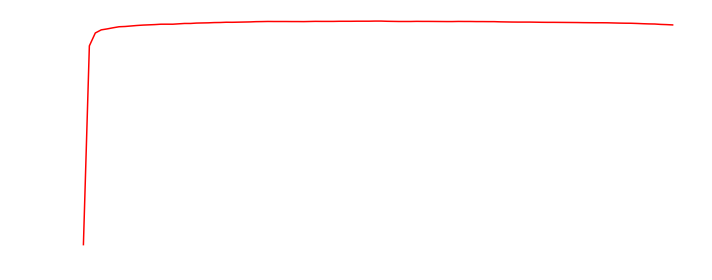

In [274]:
##### OPTIMIZE CUTOFF

# set step
step = 100

# search
cutoffs = []
profits = []
for i in range(0, step):
    cutoffs.append(i / step)
    profits.append(recompute_reward(y, preds_oof, cutoff = cutoffs[i]))
    
# results
plt.figure(figsize = (10,4))
sns.lineplot(x = cutoffs, y = profits, color = 'red')
plt.tight_layout()
print('- optimal cutoff = %.4f' % cutoffs[np.argmax(profits)])
print('- optimal profit = %.4f' % profits[np.argmax(profits)])

# 4. SUBMISSION

In [ ]:
# file name
model = 'lgb_v5'
perf  = str(round(cv_perf, 0).astype('int'))
name  = model + '_' + perf

In [ ]:
# export OOF preds
oof = pd.DataFrame({'id': train['id'], 'fraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

In [ ]:
# check submission
sub = pd.DataFrame({'id': test['id'], 'fraud': preds_test})
sub['fraud'] = np.round(sub['fraud']).astype('int')
sub.head()

In [ ]:
# export submission
sub = sub[['fraud']]
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape